# Entity Hidden State PCA Visualization

Visualize hidden states of each entity at each layer using PCA.

****Objective**: 
- Visualize how entity embeddings change across layers
- functorConfirm whether entities connected by relation (`~`) become closer in deeper layers

In [1]:
!nvidia-smi

Sun Jan 25 08:25:58 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             61W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
!pip install transformer_lens

## 1. Setup

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
from pathlib import Path
import os
import re

# Hugging FaceAuthentication (modify as needed)
# os.environ["HF_TOKEN"] = "your_token_here"

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# visualizationStyle configuration
def setup_plot_style():
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Inter', 'Helvetica', 'Arial', 'DejaVu Sans'],
        'font.size': 14,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'axes.linewidth': 1.5,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': True,
        'figure.dpi': 150,
        'savefig.dpi': 300,
    })

setup_plot_style()

## 2. model loading

In [5]:
"""
Embedding extraction utilities for analogy analysis.
Uses TransformerLens to extract residual stream activations from all layers.
"""

import logging
import torch
import json
from pathlib import Path
import os
os.environ["TRANSFORMERS_NO_FLASH_ATTN"] = "1"
from transformer_lens import HookedTransformer
from typing import NamedTuple

# Suppress TransformerLens warnings about LayerNorm centering (Gemma-2 uses RMSNorm, which is fine)
logging.getLogger("root").setLevel(logging.ERROR)


class TokenInfo(NamedTuple):
    """Information about a token's position and content."""
    token_id: int
    token_str: str
    position: int


class EmbeddingExtractor:
    """Extract embeddings from all layers of a transformer model."""

    def __init__(
        self,
        model_name: str = "google/gemma-2-2b",
        device: str = "cpu",
        dtype: torch.dtype = torch.float32,
    ):
        """
        Initialize the embedding extractor.

        Args:
            model_name: HuggingFace model name
            device: Device to run on ('cpu', 'cuda', 'mps')
            dtype: Data type for model weights
        """
        self.model_name = model_name
        self.device = device
        self.dtype = dtype
        self.model = None

    def load_model(self):
        """Load the model using TransformerLens."""
        print(f"Loading model {self.model_name}...")
        self.model = HookedTransformer.from_pretrained(
            self.model_name,
            device=self.device,
            dtype=self.dtype,
        )
        print(f"Model loaded. n_layers={self.model.cfg.n_layers}, d_model={self.model.cfg.d_model}")
        return self

    def tokenize(self, prompt: str) -> tuple[torch.Tensor, list[TokenInfo]]:
        """
        Tokenize a prompt and return token information.

        Args:
            prompt: Input text

        Returns:
            tokens: Token IDs tensor
            token_info: List of TokenInfo with position and string for each token
        """
        tokens = self.model.to_tokens(prompt, prepend_bos=True)
        token_strs = self.model.to_str_tokens(prompt, prepend_bos=True)

        token_info = [
            TokenInfo(token_id=tokens[0, i].item(), token_str=token_strs[i], position=i)
            for i in range(len(token_strs))
        ]

        return tokens, token_info

    def find_token_positions(
        self,
        token_info: list[TokenInfo],
        target_tokens: list[str],
    ) -> list[int]:
        """
        Find positions of target tokens in the tokenized sequence.

        Args:
            token_info: List of TokenInfo from tokenization
            target_tokens: List of token strings to find

        Returns:
            List of positions where target tokens appear
        """
        positions = []
        for i, info in enumerate(token_info):
            if info.token_str in target_tokens:
                positions.append(i)
        return positions

    def find_node_positions(
        self,
        token_info: list[TokenInfo],
        node_pattern: str,
    ) -> list[int]:
        """
        Find positions of tokens that make up a node (e.g., '<e1>').

        Args:
            token_info: List of TokenInfo from tokenization
            node_pattern: Pattern like '<e1>' to find

        Returns:
            List of positions for all tokens in the node
        """
        # Build the full tokenized string to find substring
        full_str = "".join([info.token_str for info in token_info])

        # Find where this pattern starts
        pattern_start = full_str.find(node_pattern)
        if pattern_start == -1:
            return []

        # Find which token positions correspond to this pattern
        positions = []
        current_pos = 0
        for i, info in enumerate(token_info):
            token_end = current_pos + len(info.token_str)
            pattern_end = pattern_start + len(node_pattern)

            # Check if this token overlaps with the pattern
            if current_pos < pattern_end and token_end > pattern_start:
                positions.append(i)

            current_pos = token_end

            # Stop if we've passed the pattern
            if current_pos >= pattern_end:
                break

        return positions

    def extract_all_layer_embeddings(
        self,
        prompt: str,
        apply_ln: bool = True,
    ) -> tuple[torch.Tensor, list[TokenInfo]]:
        """
        Extract residual stream embeddings from all layers.

        Args:
            prompt: Input text
            apply_ln: Whether to apply layer norm to embeddings (default True).
                     For each layer i, applies layer i+1's ln1 (or ln_final for last layer).
                     This normalizes the embeddings for meaningful comparison.

        Returns:
            embeddings: Tensor of shape (n_layers + 1, seq_len, d_model)
                       Layer 0 is the embedding layer, layers 1-n are after each transformer block
            token_info: List of TokenInfo for the tokenized prompt
        """
        if self.model is None:
            self.load_model()

        tokens, token_info = self.tokenize(prompt)

        # Run model and cache all residual stream activations
        _, cache = self.model.run_with_cache(
            tokens,
            names_filter=lambda name: "resid_post" in name or name == "hook_embed",
        )

        n_layers = self.model.cfg.n_layers
        seq_len = tokens.shape[1]
        d_model = self.model.cfg.d_model

        # Collect embeddings from all layers
        # Layer 0: embedding layer output
        # Layer i (i > 0): residual stream after layer i-1
        embeddings = torch.zeros(n_layers + 1, seq_len, d_model, dtype=self.dtype)

        # Embedding layer (before any transformer blocks)
        embed = cache["hook_embed"][0]
        if apply_ln:
            # Apply first layer's ln1 to embedding
            embed = self.model.blocks[0].ln1(embed)
        embeddings[0] = embed

        # After each transformer block
        for layer in range(n_layers):
            resid = cache[f"blocks.{layer}.hook_resid_post"][0]
            if apply_ln:
                if layer < n_layers - 1:
                    # Apply next layer's ln1
                    resid = self.model.blocks[layer + 1].ln1(resid)
                else:
                    # Apply final layer norm for the last layer
                    resid = self.model.ln_final(resid)
            embeddings[layer + 1] = resid

        return embeddings, token_info

    def get_node_embedding(
        self,
        embeddings: torch.Tensor,
        token_info: list[TokenInfo],
        node_pattern: str,
        layer: int,
        method: str = "mean",
        proxy_token: str | None = None,
    ) -> torch.Tensor:
        """
        Get the embedding for a node at a specific layer.

        Args:
            embeddings: Full embedding tensor (n_layers + 1, seq_len, d_model)
            token_info: Token information
            node_pattern: Pattern like '<e1>'
            layer: Which layer to extract from (0 = embedding, 1+ = after transformer blocks)
            method: 'mean' for average of all tokens, 'proxy' for specific token
            proxy_token: If method='proxy', which token to use (e.g., '1' for '<e1>')

        Returns:
            Embedding vector of shape (d_model,)
        """
        positions = self.find_node_positions(token_info, node_pattern)

        if not positions:
            raise ValueError(f"Could not find node pattern '{node_pattern}' in tokens")

        if method == "mean":
            # Average embedding of all tokens in the node
            node_embeddings = embeddings[layer, positions, :]
            return node_embeddings.mean(dim=0)

        elif method == "proxy":
            # Use a specific token as proxy
            if proxy_token is None:
                raise ValueError("proxy_token must be specified when method='proxy'")

            for pos in positions:
                if token_info[pos].token_str == proxy_token:
                    return embeddings[layer, pos, :]

            raise ValueError(f"Proxy token '{proxy_token}' not found in node '{node_pattern}'")

        else:
            raise ValueError(f"Unknown method: {method}")

    def get_functor_embedding(
        self,
        embeddings: torch.Tensor,
        token_info: list[TokenInfo],
        functor_token: str,
        occurrence: int,
        layer: int,
    ) -> torch.Tensor:
        """
        Get the embedding of a functor token (~) at a specific occurrence.

        Args:
            embeddings: Full embedding tensor
            token_info: Token information
            functor_token: The functor token (e.g., '~')
            occurrence: Which occurrence (0-indexed)
            layer: Which layer to extract from

        Returns:
            Embedding vector of shape (d_model,)
        """
        positions = []
        for i, info in enumerate(token_info):
            if functor_token in info.token_str:
                positions.append(i)

        if occurrence >= len(positions):
            raise ValueError(
                f"Occurrence {occurrence} requested but only {len(positions)} "
                f"occurrences of '{functor_token}' found"
            )

        return embeddings[layer, positions[occurrence], :]

    def find_all_occurrences(
        self,
        token_info: list[TokenInfo],
        target_token: str,
    ) -> list[int]:
        """
        Find all positions where a specific token appears.

        Args:
            token_info: Token information
            target_token: Token string to find (exact match)

        Returns:
            List of positions
        """
        return [i for i, info in enumerate(token_info) if info.token_str == target_token]

    def find_all_node_occurrences(
        self,
        token_info: list[TokenInfo],
        node_pattern: str,
    ) -> list[list[int]]:
        """
        Find all occurrences of a node pattern (e.g., '<e1>') and return their token positions.

        Args:
            token_info: List of TokenInfo from tokenization
            node_pattern: Pattern like '<e1>' to find

        Returns:
            List of lists, where each inner list contains the token positions for one occurrence
            e.g., [[2,3,4,5], [15,16,17,18]] for two occurrences of '<e1>'
        """
        # Build the full tokenized string
        full_str = "".join([info.token_str for info in token_info])

        # Find all occurrences of the pattern
        occurrences = []
        start = 0
        while True:
            pattern_start = full_str.find(node_pattern, start)
            if pattern_start == -1:
                break

            # Find which token positions correspond to this pattern occurrence
            positions = []
            current_pos = 0
            pattern_end = pattern_start + len(node_pattern)

            for i, info in enumerate(token_info):
                token_end = current_pos + len(info.token_str)

                # Check if this token overlaps with the pattern
                if current_pos < pattern_end and token_end > pattern_start:
                    positions.append(i)

                current_pos = token_end

                # Stop if we've passed the pattern
                if current_pos >= pattern_end:
                    break

            if positions:
                occurrences.append(positions)

            # Move past this occurrence
            start = pattern_start + 1

        return occurrences

    def get_node_embedding_by_occurrence_mean(
        self,
        embeddings: torch.Tensor,
        token_info: list[TokenInfo],
        node_pattern: str,
        occurrence: int,
        layer: int,
    ) -> torch.Tensor:
        """
        Get the mean embedding of a node at a specific occurrence.

        This uses all tokens that make up the node (e.g., '<', 'e', '1', '>') and
        averages their embeddings.

        Args:
            embeddings: Full embedding tensor (n_layers + 1, seq_len, d_model)
            token_info: Token information
            node_pattern: Pattern like '<e1>'
            occurrence: Which occurrence (-1 for last, 0 for first, etc.)
            layer: Which layer to extract from

        Returns:
            Mean embedding vector of shape (d_model,)
        """
        all_occurrences = self.find_all_node_occurrences(token_info, node_pattern)
        print(token_info, all_occurrences)

        if not all_occurrences:
            raise ValueError(f"Node pattern '{node_pattern}' not found in sequence")

        # Handle negative indexing (e.g., -1 for last)
        if occurrence < 0:
            occurrence = len(all_occurrences) + occurrence

        if occurrence < 0 or occurrence >= len(all_occurrences):
            raise ValueError(
                f"Occurrence {occurrence} out of range. "
                f"Pattern '{node_pattern}' appears {len(all_occurrences)} times."
            )

        positions = all_occurrences[occurrence]
        # Get embeddings for all tokens in this occurrence and average
        node_embeddings = embeddings[layer, positions, :]
        return node_embeddings.mean(dim=0)

    def get_node_embedding_by_occurrence(
        self,
        embeddings: torch.Tensor,
        token_info: list[TokenInfo],
        proxy_token: str,
        occurrence: int,
        layer: int,
    ) -> torch.Tensor:
        """
        Get embedding of a node using a proxy token at a specific occurrence.

        Args:
            embeddings: Full embedding tensor
            token_info: Token information
            proxy_token: The token to use as proxy (e.g., '1' for '<e1>')
            occurrence: Which occurrence (-1 for last, 0 for first, etc.)
            layer: Which layer to extract from

        Returns:
            Embedding vector of shape (d_model,)
        """
        positions = self.find_all_occurrences(token_info, proxy_token)

        if not positions:
            raise ValueError(f"Token '{proxy_token}' not found in sequence")

        # Handle negative indexing (e.g., -1 for last)
        if occurrence < 0:
            occurrence = len(positions) + occurrence

        if occurrence < 0 or occurrence >= len(positions):
            raise ValueError(
                f"Occurrence {occurrence} out of range. "
                f"Token '{proxy_token}' appears {len(positions)} times."
            )

        pos = positions[occurrence]
        return embeddings[layer, pos, :]


def load_sample(sample_path: str | Path) -> dict:
    """Load a sample JSON file."""
    with open(sample_path, "r") as f:
        return json.load(f)


def print_tokenization(token_info: list[TokenInfo]):
    """Pretty print tokenization information."""
    print("\nTokenization:")
    print("-" * 50)
    for info in token_info:
        print(f"  Position {info.position:3d}: '{info.token_str}' (id={info.token_id})")
    print("-" * 50)


In [6]:
%env HF_TOKEN=YOUR_HF_TOKEN

env: HF_TOKEN=YOUR_HF_TOKEN


In [7]:
import torch
import gc

# PyTorch clear GPU cache
torch.cuda.empty_cache()
# Python run garbage collection
gc.collect()
MODEL_NAME = "google/gemma-2-2b"
DTYPE = torch.float32

extractor = EmbeddingExtractor(
    model_name=MODEL_NAME,
    device=DEVICE,
    dtype=DTYPE,
)
extractor.load_model()

Loading model google/gemma-2-2b...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Loaded pretrained model google/gemma-2-2b into HookedTransformer
Model loaded. n_layers=26, d_model=2304


## 3. Sample loading and embedding extraction

In [8]:
# Sample loading
sample = {
    "name": "abstract_analogy_1",
    "prompt": "<e1>a<e2>, <e1>b<e3>. <e6>a<e4>, <e6>b<e7>. <e1>~<e6>, <e3>~<e",
    "target_token": "7",
    "description": "Abstract analogy reasoning task with entity placeholders",
    "graph": {
        "nodes": ["<e1>", "<e6>"],
        "edges": [
            {"source": "<e1>", "target": "<e6>", "type": "functor"}
        ]
    },
    "functor_symbol": "~",
    "node_positions": {
        "<e1>": {"proxy_token": "1", "occurrence": -1, "description": "Last occurrence (in <e1>~<e6>)"},
        "<e6>": {"proxy_token": "6", "occurrence": -1, "description": "Last occurrence (in <e1>~<e6>)"}
    },
    "notes": "Only <e1>~<e6> edge is used for Dirichlet energy. <e3>~<e7> is incomplete in prompt (<e7> is the target to predict)."
}

prompt = sample["prompt"]
target_token = sample["target_token"]
sample_name = sample.get("name", "sample")

# configuration
APPLY_RMSNORM = True

print(f"Sample: {sample_name}")
print(f"Prompt: {repr(prompt)}")
print(f"Target token: '{target_token}'")
print(f"Apply RMSNorm: {APPLY_RMSNORM}")

Sample: abstract_analogy_1
Prompt: '<e1>a<e2>, <e1>b<e3>. <e6>a<e4>, <e6>b<e7>. <e1>~<e6>, <e3>~<e'
Target token: '7'
Apply RMSNorm: True


In [9]:
# embedding extraction
embeddings, token_info = extractor.extract_all_layer_embeddings(prompt, apply_ln=APPLY_RMSNORM)
print(f"Embeddings shape: {embeddings.shape}")
print(f"  - n_layers + 1: {embeddings.shape[0]}")
print(f"  - seq_len: {embeddings.shape[1]}")
print(f"  - d_model: {embeddings.shape[2]}")

print_tokenization(token_info)

Embeddings shape: torch.Size([27, 53, 2304])
  - n_layers + 1: 27
  - seq_len: 53
  - d_model: 2304

Tokenization:
--------------------------------------------------
  Position   0: '<bos>' (id=2)
  Position   1: '<' (id=235322)
  Position   2: 'e' (id=235249)
  Position   3: '1' (id=235274)
  Position   4: '>' (id=235313)
  Position   5: 'a' (id=235250)
  Position   6: '<' (id=235322)
  Position   7: 'e' (id=235249)
  Position   8: '2' (id=235284)
  Position   9: '>,' (id=14514)
  Position  10: ' <' (id=968)
  Position  11: 'e' (id=235249)
  Position  12: '1' (id=235274)
  Position  13: '>' (id=235313)
  Position  14: 'b' (id=235268)
  Position  15: '<' (id=235322)
  Position  16: 'e' (id=235249)
  Position  17: '3' (id=235304)
  Position  18: '>.' (id=32229)
  Position  19: ' <' (id=968)
  Position  20: 'e' (id=235249)
  Position  21: '6' (id=235318)
  Position  22: '>' (id=235313)
  Position  23: 'a' (id=235250)
  Position  24: '<' (id=235322)
  Position  25: 'e' (id=235249)
  Posit

## 4. Entity identification and embedding extraction

In [10]:
def find_all_entities(prompt: str) -> list[str]:
    """Extract all entities (<e1>, <e2>, ...) from prompt"""
    pattern = r'<e\d+>'
    entities = re.findall(pattern, prompt)
    return sorted(set(entities), key=lambda x: int(x[2:-1]))

def get_entity_proxy_token(entity: str) -> str:
    """Get proxy token (numeric part) from entity"""
    return entity[2:-1]  # '<e1>' -> '1'

# Identify entities in prompt
entities = find_all_entities(prompt)
print(f"Found entities: {entities}")

Found entities: ['<e1>', '<e2>', '<e3>', '<e4>', '<e6>', '<e7>']


In [105]:
def extract_entity_embeddings_all_layers(
    extractor,
    embeddings: torch.Tensor,
    token_info: list,
    entities: list[str],
    method: str = "mean",
) -> dict:
    """
    Extract embedding for each entity at each layer
    
    Args:
        extractor: EmbeddingExtractor
        embeddings: (n_layers + 1, seq_len, d_model)
        token_info: tokenlist of information
        entities: Entity list ['<e1>', '<e2>', ...]
        method: 'mean' (mean of all tokens) or 'proxy' (numeric token only)
    
    Returns:
        dict: {entity: tensor of shape (n_layers + 1, d_model)}
    """
    print(embeddings.shape)
    n_layers = embeddings.shape[0]
    entity_embeddings = {}
    
    for entity in entities:
        entity_embs = []
        proxy_token = get_entity_proxy_token(entity)
        
        for layer in range(n_layers):
            if method == "mean":
                # Mean of all tokens for entity
                
                emb = extractor.get_node_embedding_by_occurrence_mean(
                    embeddings, token_info, entity, occurrence=-1, layer=layer
                )
                # except ValueError:
                #     # Fallback to proxy if not found
                #     emb = extractor.get_node_embedding_by_occurrence(
                #         embeddings, token_info, proxy_token, occurrence=-1, layer=layer
                #     )
            else:  # proxy
                emb = extractor.get_node_embedding_by_occurrence(
                    embeddings, token_info, proxy_token, occurrence=-1, layer=layer
                )
            entity_embs.append(emb)
        
        entity_embeddings[entity] = torch.stack(entity_embs)
    
    return entity_embeddings

# Extract embedding for each entity
entity_embeddings = extract_entity_embeddings_all_layers(
    extractor, embeddings, token_info, entities, method="proxy", #"mean"
)
print("\nExtracted entity embeddings:")
for entity, emb in entity_embeddings.items():
    print(f"  {entity}: shape {emb.shape}")

torch.Size([27, 53, 2304])

Extracted entity embeddings:
  <e1>: shape torch.Size([27, 2304])
  <e2>: shape torch.Size([27, 2304])
  <e3>: shape torch.Size([27, 2304])
  <e4>: shape torch.Size([27, 2304])
  <e6>: shape torch.Size([27, 2304])
  <e7>: shape torch.Size([27, 2304])


## 5. PCA visualization per layer

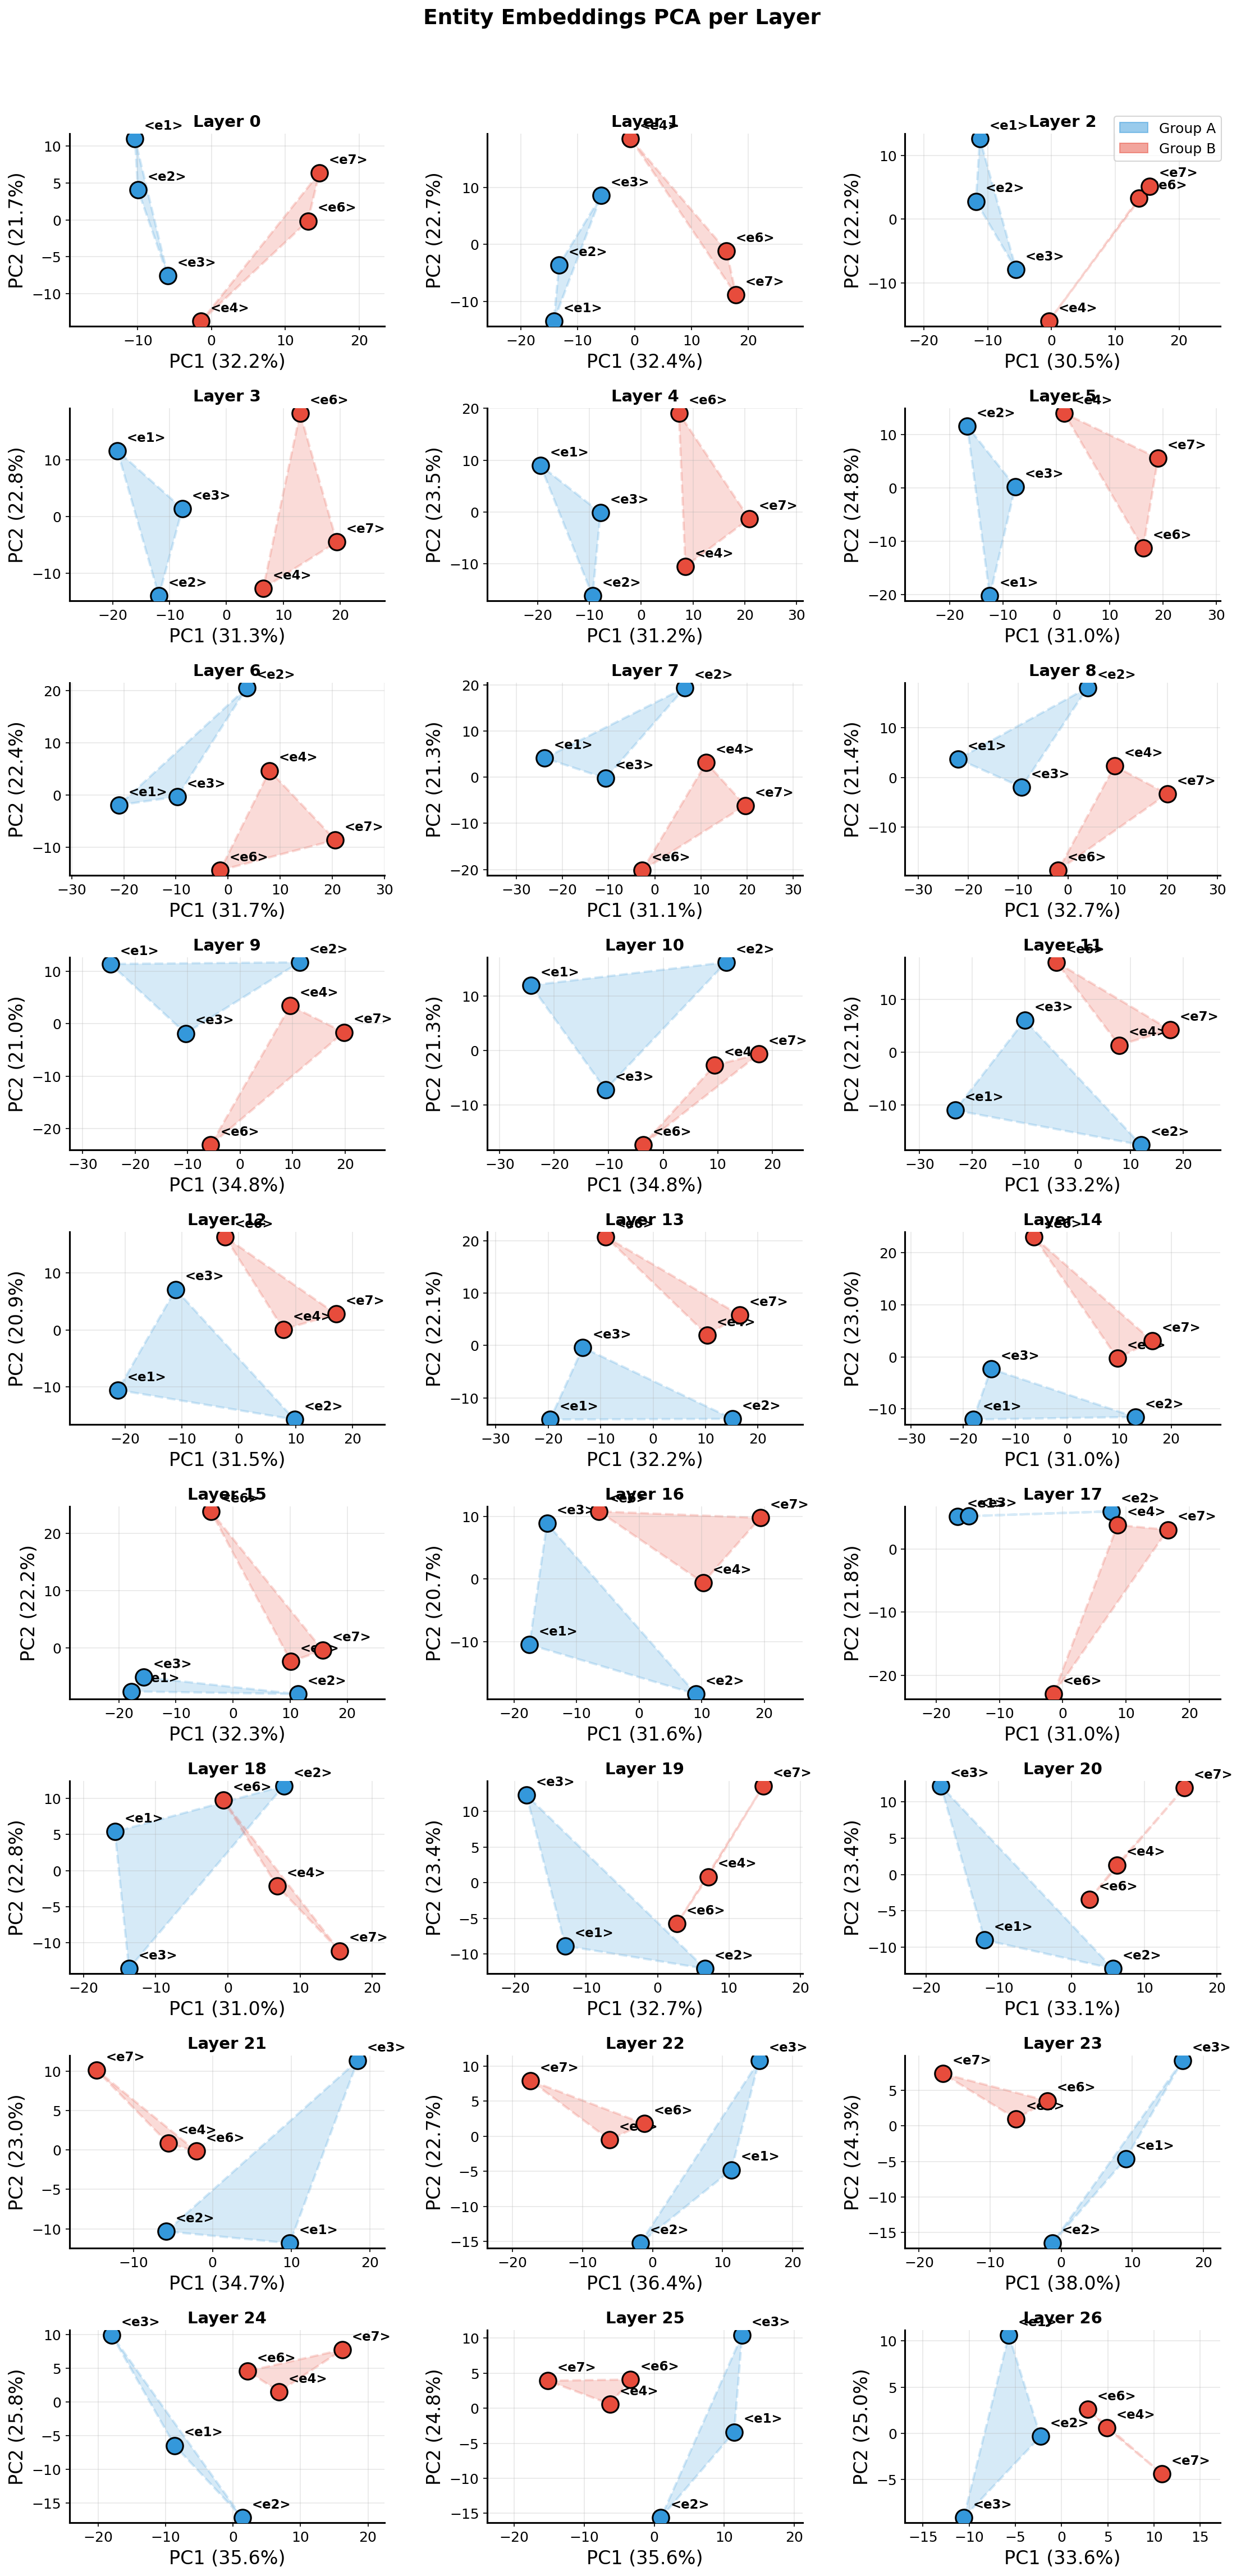

PCA(n_components=2)

In [81]:



def visualize_pca_per_layer(
    entity_embeddings: dict,
    layers_to_plot: list[int] = None,
    n_components: int = 2,
    figsize: tuple = (16, 12),
    save_path: str = None,
    entity_groups: dict = None,
):
    """
    Visualize entity embeddings at each layer using PCA
    Entities in the same group are enclosed in polygons with the same color
    """
    from scipy.spatial import ConvexHull
    from matplotlib.patches import Polygon, Patch
    
    entities = list(entity_embeddings.keys())
    n_layers = next(iter(entity_embeddings.values())).shape[0]
    
    # Default group configuration
    if entity_groups is None:
        entity_groups = {
            "Group A": ["<e1>", "<e2>", "<e3>"],
            "Group B": ["<e6>", "<e4>", "<e7>"],
        }
    
    # Configure colors for each group
    group_colors = {
        "Group A": "#3498db",  # blue
        "Group B": "#e74c3c",  # red
    }
    
    # Entity to group mapping
    entity_to_group = {}
    for group_name, group_entities in entity_groups.items():
        for e in group_entities:
            entity_to_group[e] = group_name
    
    if layers_to_plot is None:
        if n_layers <= 6:
            layers_to_plot = list(range(n_layers))
        else:
            layers_to_plot = [0, n_layers // 4, n_layers // 2, 3 * n_layers // 4, n_layers - 1]
    
    n_plots = len(layers_to_plot)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, layer in enumerate(layers_to_plot):
        ax = axes[idx]
        
        # Collect embeddings of all entities at this layer
        layer_embs = []
        for entity in entities:
            emb = entity_embeddings[entity][layer].detach().cpu().numpy()
            layer_embs.append(emb)
        
        layer_embs = np.array(layer_embs)
        
        # PCA
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(layer_embs)
        
        # Draw polygon for each group
        for group_name, group_entities in entity_groups.items():
            group_indices = [i for i, e in enumerate(entities) if e in group_entities]
            if len(group_indices) < 3:
                continue
            
            group_points = pca_result[group_indices]
            
            try:
                hull = ConvexHull(group_points)
                hull_points = group_points[hull.vertices]
                
                polygon = Polygon(
                    hull_points,
                    alpha=0.2,
                    facecolor=group_colors.get(group_name, "#999999"),
                    edgecolor=group_colors.get(group_name, "#999999"),
                    linewidth=2,
                    linestyle="--"
                )
                ax.add_patch(polygon)
            except:
                pass
        
        # Plot each entity
        for i, entity in enumerate(entities):
            group = entity_to_group.get(entity, None)
            color = group_colors.get(group, "#999999") if group else "#999999"
            
            ax.scatter(
                pca_result[i, 0], pca_result[i, 1],
                c=[color], s=200,
                edgecolors='black', linewidths=1.5,
                zorder=10
            )
            ax.annotate(
                entity, (pca_result[i, 0], pca_result[i, 1]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold'
            )
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_title(f'Layer {layer}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='datalim')
    
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    # Legend
    legend_elements = [
        Patch(facecolor=color, alpha=0.5, edgecolor=color, label=name)
        for name, color in group_colors.items()
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    fig.suptitle('Entity Embeddings PCA per Layer', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
    return pca

# visualization
n_layers = embeddings.shape[0]
entity_groups = {
    "Group A": ["<e1>", "<e2>", "<e3>"],
    "Group B": ["<e6>", "<e4>", "<e7>"],
}

visualize_pca_per_layer(
    entity_embeddings,
    layers_to_plot=list(range(n_layers)),
    figsize=(15, 30),
    entity_groups=entity_groups,
)

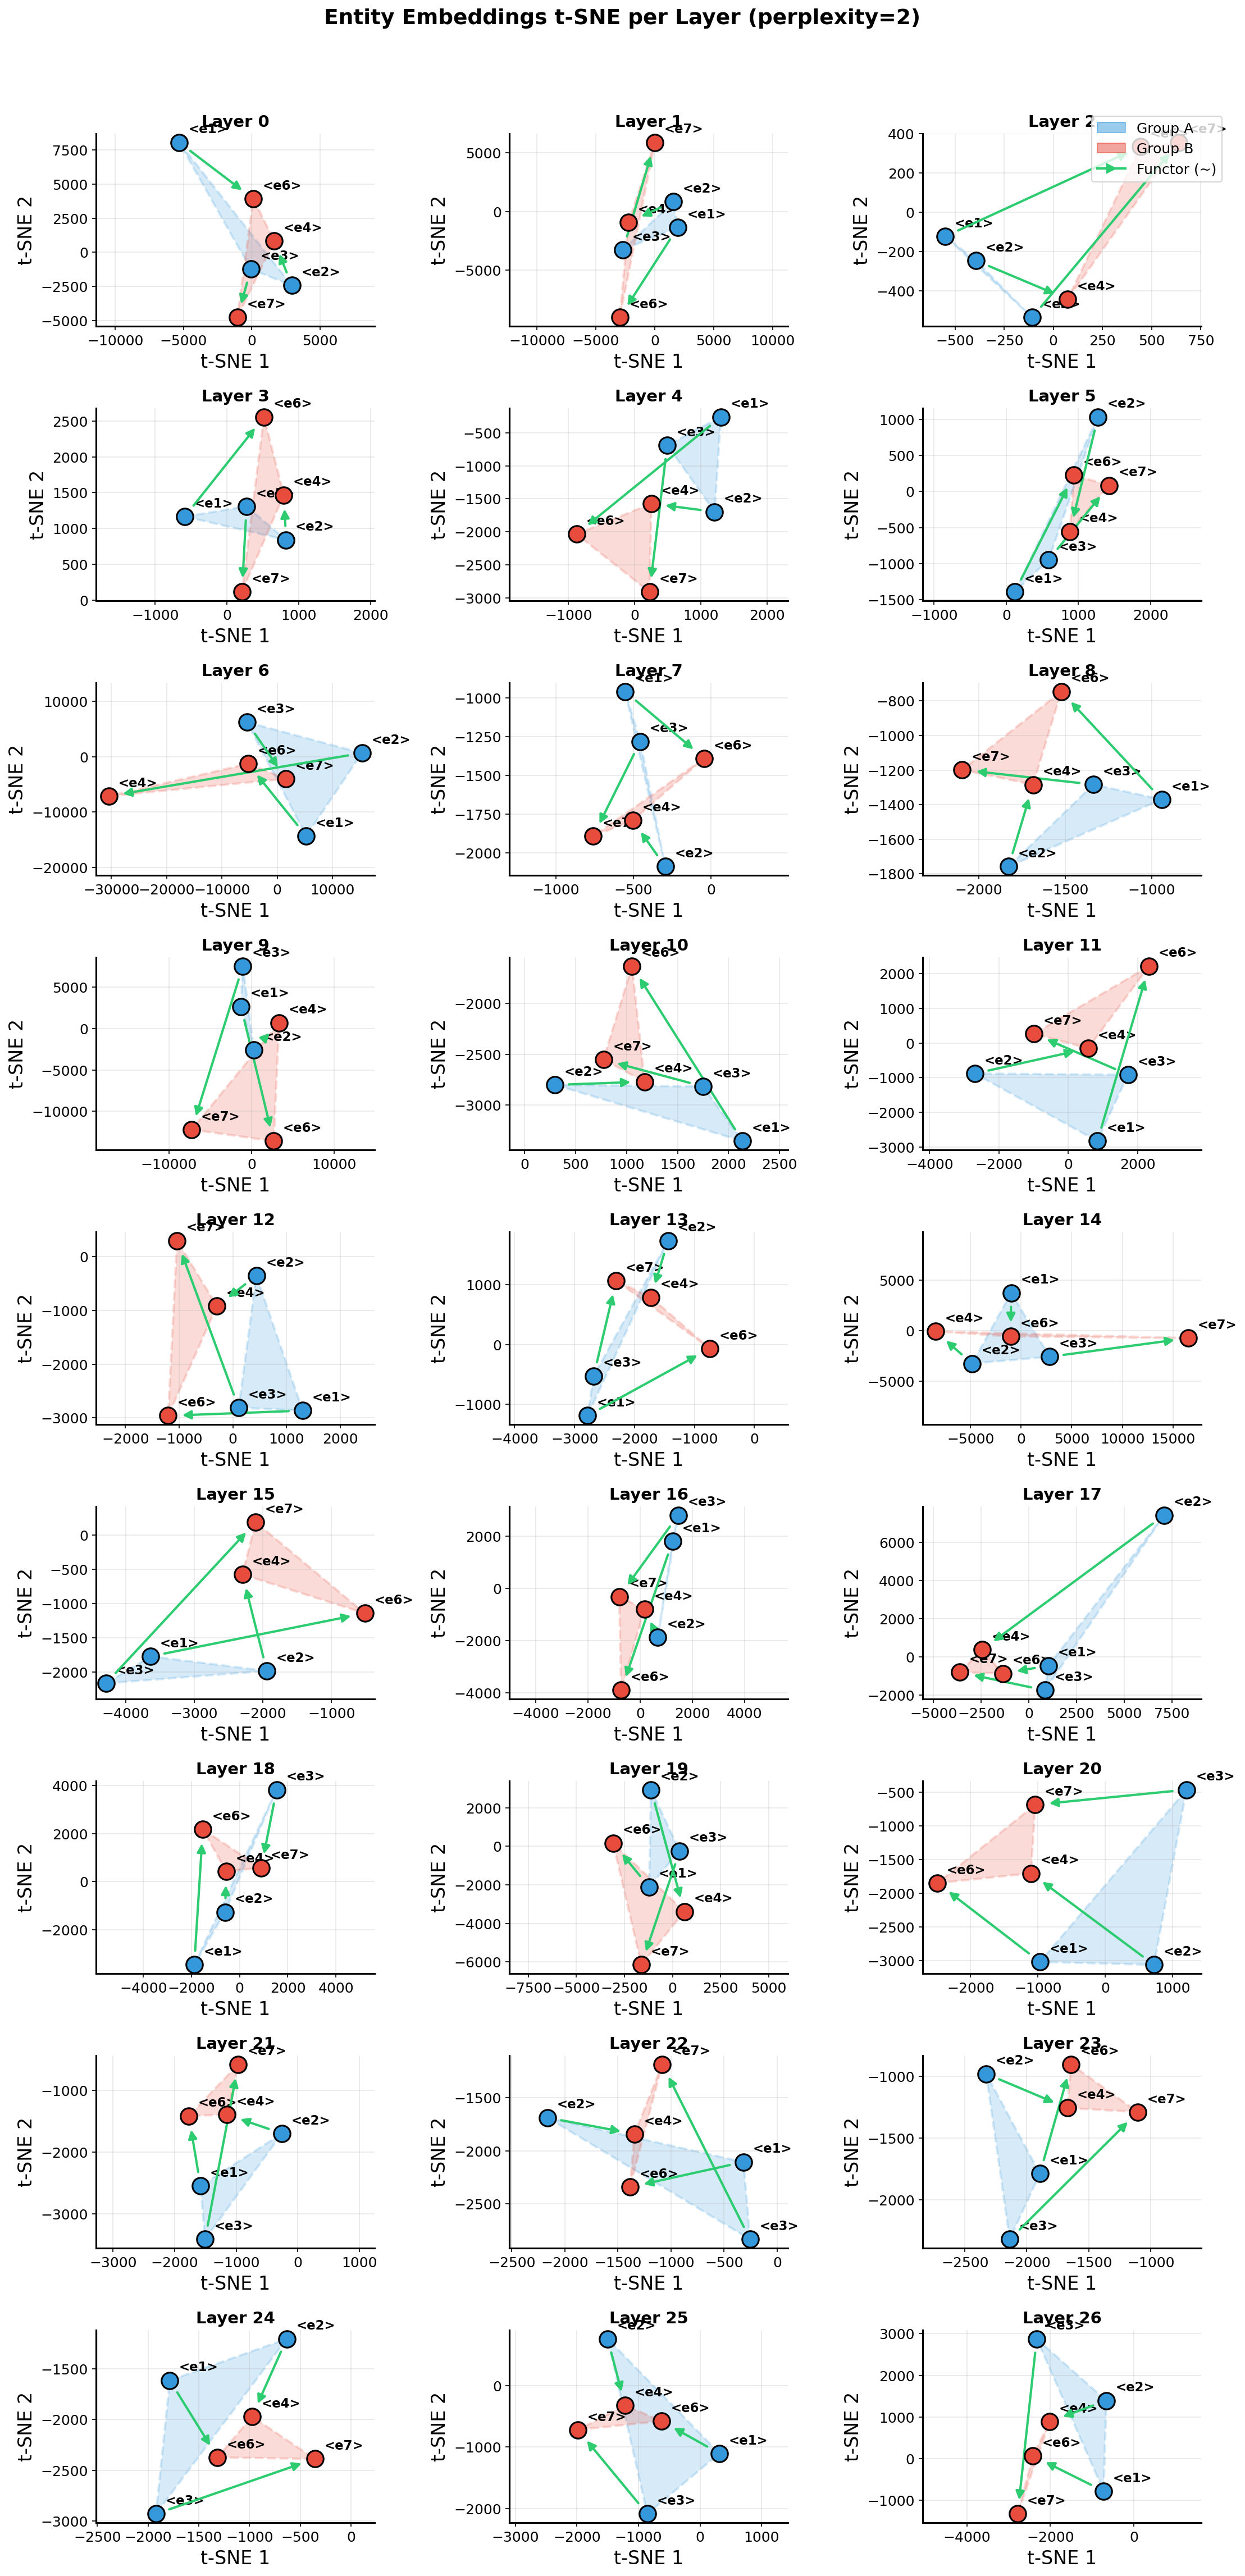

In [98]:
def visualize_tsne_per_layer(
    entity_embeddings: dict,
    layers_to_plot: list[int] = None,
    n_components: int = 2,
    figsize: tuple = (16, 12),
    save_path: str = None,
    entity_groups: dict = None,
    functor_pairs: list = None,
    perplexity: float = 5,
    random_state: int = 42,
    init: str = 'random',
    early_exaggeration: float = 12,
):
    from sklearn.manifold import TSNE
    from scipy.spatial import ConvexHull
    from matplotlib.patches import Polygon, Patch, FancyArrowPatch
    from matplotlib.lines import Line2D
    
    entities = list(entity_embeddings.keys())
    n_layers = next(iter(entity_embeddings.values())).shape[0]
    n_entities = len(entities)
    
    perplexity = min(perplexity, n_entities - 1)
    
    if entity_groups is None:
        entity_groups = {
            "Group A": ["<e1>", "<e2>", "<e3>"],
            "Group B": ["<e6>", "<e4>", "<e7>"],
        }
    
    if functor_pairs is None:
        functor_pairs = [
            ("<e1>", "<e6>"),
            ("<e2>", "<e4>"),
            ("<e3>", "<e7>"),
        ]
    
    group_colors = {"Group A": "#3498db", "Group B": "#e74c3c"}
    
    entity_to_group = {}
    for group_name, group_entities in entity_groups.items():
        for e in group_entities:
            entity_to_group[e] = group_name
    
    entity_to_idx = {e: i for i, e in enumerate(entities)}
    
    if layers_to_plot is None:
        if n_layers <= 6:
            layers_to_plot = list(range(n_layers))
        else:
            layers_to_plot = [0, n_layers // 4, n_layers // 2, 3 * n_layers // 4, n_layers - 1]
    
    n_plots = len(layers_to_plot)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, layer in enumerate(layers_to_plot):
        ax = axes[idx]
        
        layer_embs = []
        for entity in entities:
            emb = entity_embeddings[entity][layer].detach().cpu().numpy()
            layer_embs.append(emb)
        
        layer_embs = np.array(layer_embs)
        
        tsne = TSNE(
            n_components=n_components,
            perplexity=perplexity,
            random_state=random_state,
            init=init,
            learning_rate='auto',
            early_exaggeration=early_exaggeration,
        )
        tsne_result = tsne.fit_transform(layer_embs)
        
        # Draw polygon
        for group_name, group_entities in entity_groups.items():
            group_indices = [i for i, e in enumerate(entities) if e in group_entities]
            if len(group_indices) < 3:
                continue
            group_points = tsne_result[group_indices]
            try:
                hull = ConvexHull(group_points)
                hull_points = group_points[hull.vertices]
                polygon = Polygon(
                    hull_points, alpha=0.2,
                    facecolor=group_colors.get(group_name, "#999999"),
                    edgecolor=group_colors.get(group_name, "#999999"),
                    linewidth=2, linestyle="--"
                )
                ax.add_patch(polygon)
            except:
                pass
        
        # functorArrow to draw
        for src, tgt in functor_pairs:
            if src in entity_to_idx and tgt in entity_to_idx:
                src_pos = tsne_result[entity_to_idx[src]]
                tgt_pos = tsne_result[entity_to_idx[tgt]]
                arrow = FancyArrowPatch(
                    posA=(src_pos[0], src_pos[1]),
                    posB=(tgt_pos[0], tgt_pos[1]),
                    arrowstyle='-|>',
                    mutation_scale=15,
                    color='#2ecc71',
                    linewidth=2,
                    zorder=5,
                    shrinkA=12,
                    shrinkB=12,
                )
                ax.add_patch(arrow)
        
        # Plot entities
        for i, entity in enumerate(entities):
            group = entity_to_group.get(entity, None)
            color = group_colors.get(group, "#999999") if group else "#999999"
            ax.scatter(
                tsne_result[i, 0], tsne_result[i, 1],
                c=[color], s=200,
                edgecolors='black', linewidths=1.5, zorder=10
            )
            ax.annotate(
                entity, (tsne_result[i, 0], tsne_result[i, 1]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold'
            )
        
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.set_title(f'Layer {layer}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='datalim')
    
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    legend_elements = [
        Patch(facecolor=color, alpha=0.5, edgecolor=color, label=name)
        for name, color in group_colors.items()
    ]
    legend_elements.append(
        Line2D([0], [0], color='#2ecc71', linewidth=2, marker='>', markersize=8, label='Functor (~)')
    )
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    fig.suptitle(f'Entity Embeddings t-SNE per Layer (perplexity={perplexity})', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Execution
n_layers = embeddings.shape[0]
entity_groups = {
    "Group A": ["<e1>", "<e2>", "<e3>"],
    "Group B": ["<e6>", "<e4>", "<e7>"],
}
functor_pairs = [
    ("<e1>", "<e6>"),
    ("<e2>", "<e4>"),
    ("<e3>", "<e7>"),
]

visualize_tsne_per_layer(
    entity_embeddings,
    layers_to_plot=list(range(n_layers)),
    figsize=(15, 30),
    entity_groups=entity_groups,
    functor_pairs=functor_pairs,
    perplexity=2,
    random_state=28, #3
    init='random', 
    early_exaggeration=1000,
)

Explained variance: PC1=12.7%, PC2=8.7%


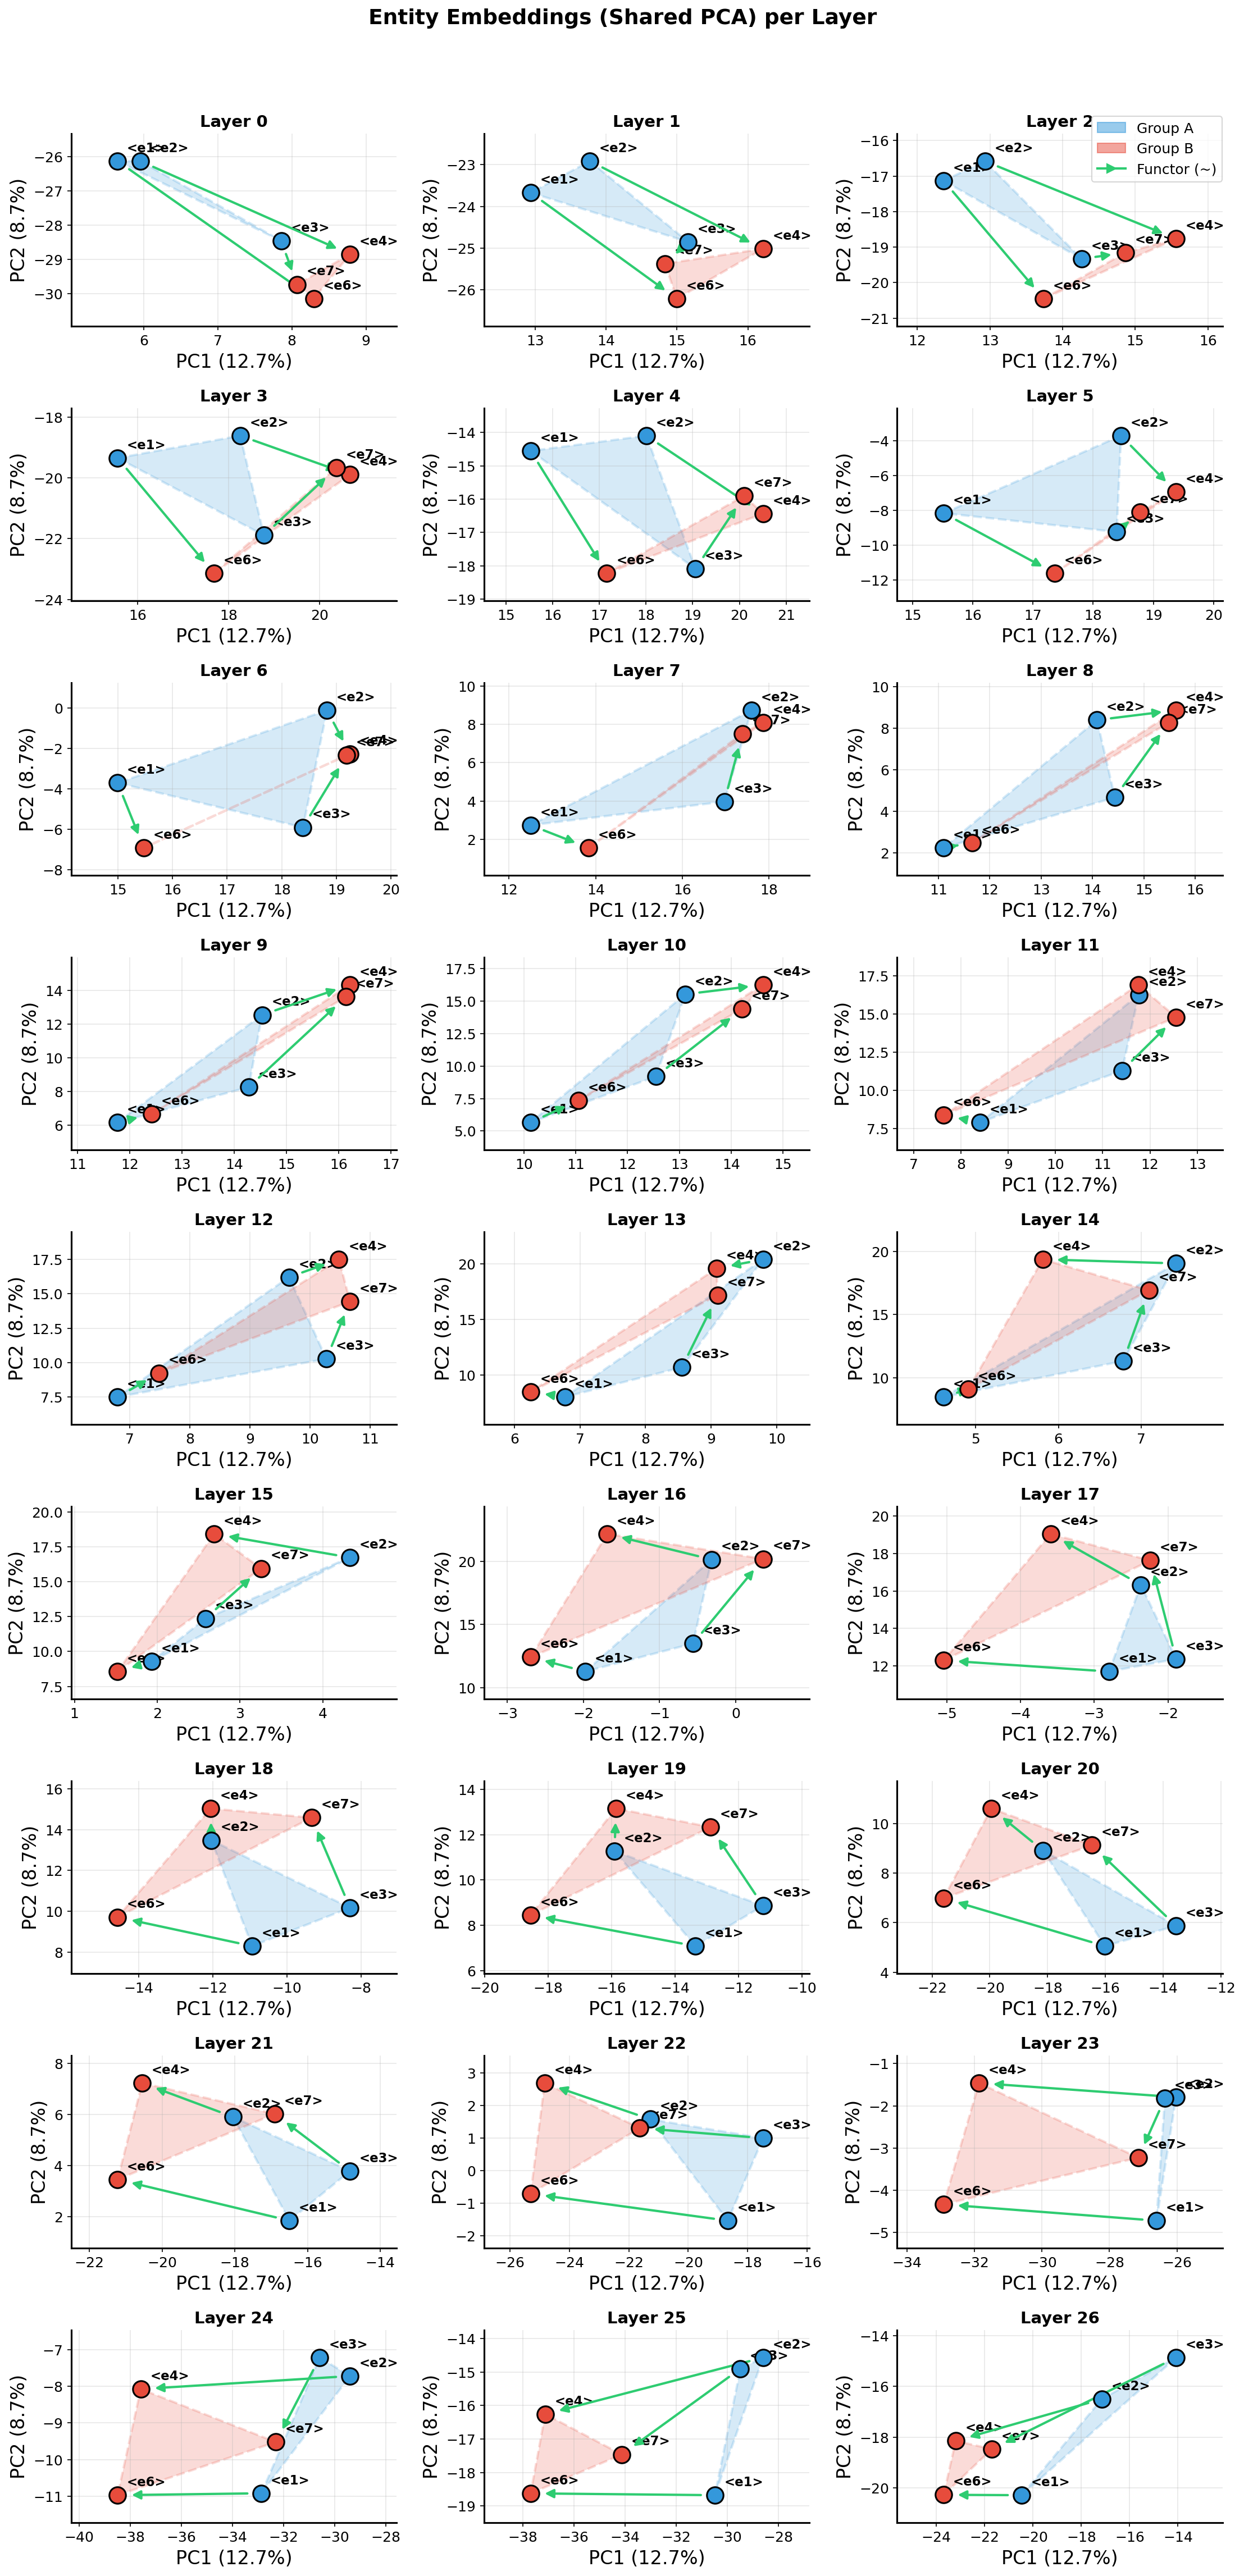

PCA(n_components=2)

In [106]:
def visualize_shared_pca_per_layer(
    entity_embeddings: dict,
    layers_to_plot: list[int] = None,
    figsize: tuple = (16, 12),
    save_path: str = None,
    entity_groups: dict = None,
    functor_pairs: list = None,
    normalize: bool = True,  # normalizationOptions
    shared_axes: bool = False,  # Whether to share axis range
):
    """
    Train common PCA on all layer data, visualize in same coordinate system
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from scipy.spatial import ConvexHull
    from matplotlib.patches import Polygon, Patch, FancyArrowPatch
    from matplotlib.lines import Line2D
    
    entities = list(entity_embeddings.keys())
    n_layers = next(iter(entity_embeddings.values())).shape[0]
    
    if entity_groups is None:
        entity_groups = {
            "Group A": ["<e1>", "<e2>", "<e3>"],
            "Group B": ["<e6>", "<e4>", "<e7>"],
        }
    
    if functor_pairs is None:
        functor_pairs = [
            ("<e1>", "<e6>"),
            ("<e2>", "<e4>"),
            ("<e3>", "<e7>"),
        ]
    
    group_colors = {"Group A": "#3498db", "Group B": "#e74c3c"}
    
    entity_to_group = {}
    for group_name, group_entities in entity_groups.items():
        for e in group_entities:
            entity_to_group[e] = group_name
    
    entity_to_idx = {e: i for i, e in enumerate(entities)}
    
    # === === Collect embeddings for each layer ===
    layer_embs_dict = {}
    for layer in range(n_layers):
        layer_embs = []
        for entity in entities:
            emb = entity_embeddings[entity][layer].detach().cpu().numpy()
            layer_embs.append(emb)
        layer_embs_dict[layer] = np.array(layer_embs)
    
    # Combine all data
    all_embs = np.vstack([layer_embs_dict[l] for l in range(n_layers)])
    
    # normalization（optional)
    if normalize:
        scaler = StandardScaler()
        all_embs_scaled = scaler.fit_transform(all_embs)
    else:
        all_embs_scaled = all_embs
    
    # Train common PCA
    pca = PCA(n_components=2)
    pca.fit(all_embs_scaled)
    print(f"Explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")
    
    # Project each layer's embeddings to common PCA space
    layer_pca_results = {}
    for layer in range(n_layers):
        if normalize:
            layer_scaled = scaler.transform(layer_embs_dict[layer])
        else:
            layer_scaled = layer_embs_dict[layer]
        layer_pca_results[layer] = pca.transform(layer_scaled)
    
    if layers_to_plot is None:
        if n_layers <= 6:
            layers_to_plot = list(range(n_layers))
        else:
            layers_to_plot = [0, n_layers // 4, n_layers // 2, 3 * n_layers // 4, n_layers - 1]
    
    n_plots = len(layers_to_plot)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, layer in enumerate(layers_to_plot):
        ax = axes[idx]
        pca_result = layer_pca_results[layer]
        
        # Draw polygon
        for group_name, group_entities in entity_groups.items():
            group_indices = [i for i, e in enumerate(entities) if e in group_entities]
            if len(group_indices) < 3:
                continue
            group_points = pca_result[group_indices]
            try:
                hull = ConvexHull(group_points)
                hull_points = group_points[hull.vertices]
                polygon = Polygon(
                    hull_points, alpha=0.2,
                    facecolor=group_colors.get(group_name, "#999999"),
                    edgecolor=group_colors.get(group_name, "#999999"),
                    linewidth=2, linestyle="--"
                )
                ax.add_patch(polygon)
            except:
                pass
        
        # functorArrow
        for src, tgt in functor_pairs:
            if src in entity_to_idx and tgt in entity_to_idx:
                src_pos = pca_result[entity_to_idx[src]]
                tgt_pos = pca_result[entity_to_idx[tgt]]
                arrow = FancyArrowPatch(
                    posA=(src_pos[0], src_pos[1]),
                    posB=(tgt_pos[0], tgt_pos[1]),
                    arrowstyle='-|>',
                    mutation_scale=15,
                    color='#2ecc71',
                    linewidth=2,
                    zorder=5,
                    shrinkA=12,
                    shrinkB=12,
                )
                ax.add_patch(arrow)
        
        # Plot entities
        for i, entity in enumerate(entities):
            group = entity_to_group.get(entity, None)
            color = group_colors.get(group, "#999999") if group else "#999999"
            ax.scatter(
                pca_result[i, 0], pca_result[i, 1],
                c=[color], s=200,
                edgecolors='black', linewidths=1.5, zorder=10
            )
            ax.annotate(
                entity, (pca_result[i, 0], pca_result[i, 1]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=11, fontweight='bold'
            )
        
        # Auto-adjust axis range for each layer (when shared_axes=False)
        if not shared_axes:
            x_vals = pca_result[:, 0]
            y_vals = pca_result[:, 1]
            x_margin = 0.2 * (x_vals.max() - x_vals.min() + 1e-6)
            y_margin = 0.2 * (y_vals.max() - y_vals.min() + 1e-6)
            ax.set_xlim(x_vals.min() - x_margin, x_vals.max() + x_margin)
            ax.set_ylim(y_vals.min() - y_margin, y_vals.max() + y_margin)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_title(f'Layer {layer}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    legend_elements = [
        Patch(facecolor=color, alpha=0.5, edgecolor=color, label=name)
        for name, color in group_colors.items()
    ]
    legend_elements.append(
        Line2D([0], [0], color='#2ecc71', linewidth=2, marker='>', markersize=8, label='Functor (~)')
    )
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    fig.suptitle('Entity Embeddings (Shared PCA) per Layer', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    return pca

# Execution
n_layers = embeddings.shape[0]
entity_groups = {
    "Group A": ["<e1>", "<e2>", "<e3>"],
    "Group B": ["<e6>", "<e4>", "<e7>"],
}
functor_pairs = [
    ("<e1>", "<e6>"),
    ("<e2>", "<e4>"),
    ("<e3>", "<e7>"),
]

visualize_shared_pca_per_layer(
    entity_embeddings,
    layers_to_plot=list(range(n_layers)),
    figsize=(15, 30),
    entity_groups=entity_groups,
    functor_pairs=functor_pairs,
    normalize=True,   # normalizationON
    shared_axes=False,  # Auto-adjust axes for each layer
)